Let's measure the relationship between the values of an attribute from the values of another attribute. 

# Load Data

Create a dataframe with two columns: document labels and textual tokens:

In [10]:
#!python3 -m spacy download en
import pysolr
import requests
import json
import pandas as pd
import os
from datetime import datetime

# Set a local folder where models will be saved.
base_directory = os.getcwd()
print(base_directory)

# Setup a Solr instance. The timeout is optional.
solr = pysolr.Solr('http://librairy.linkeddata.es/data/covid-sentences')

# Set the query to filter the documents
solr_query="bionlp_atc5_t:[* TO *] AND scispacy_diseases_t:[* TO *]"

def get_key_tokens(document):
    keys = document["bionlp_atc5_t"].split(" ")
    tokens = ""
    for token in document['scispacy_diseases_t'].split(" "):
        if len(token)>2 and token.isalnum():
            tokens += token + " "
    return (keys,tokens)

# Create a dictionary with all the attribute values.
counter = 0
completed = False
window_size=1000
cursor = "*"
data={}
print("reading documents...")
while (not completed):
    old_counter = counter
    try:
        documents = solr.search(q=solr_query,rows=window_size,cursorMark=cursor,sort="id asc")
        cursor = documents.nextCursorMark
        counter += len(documents)
        for document in documents:
            keys, tokens = get_key_tokens(document)
            for key in keys:
                if (not key in data):
                    data[key]=""
                data[key] += tokens
        if (old_counter == counter):
            print("done!")
            break
    except:
        print("Solr query error. Wait for 5secs..")
        time.sleep(5.0)
        
print(len(data.keys()),"attributes")               

/Users/cbadenes/Projects/librairy/public/api/src/test/notebook
reading documents...
done!
2687 attributes


# Vectorial data representation

## term frequency matrix

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

count_vect = CountVectorizer()

X_freq = count_vect.fit_transform(list(data.values()))

df_freq = pd.DataFrame(X_freq.toarray(),columns=count_vect.get_feature_names(),index=data.keys())
df_freq

,1002,1006magnification,10412535,11036,11052,111,124,1493,17d,1852,...,zooepidemicus,zoster,zprmsole,zsofia,zst,zuccotti,zueva,zuniga,zygomycosis,zygraich
J07BB01,0,1,0,1,1,1,0,1,12,0,...,6,19,0,1,0,0,0,8,0,3
J07BH01,0,1,0,1,1,1,0,1,12,0,...,6,19,0,1,0,0,0,8,0,3
J07BG01,0,1,0,1,1,1,0,1,12,0,...,6,19,0,1,0,0,0,8,0,3
J07BC02,0,1,0,1,1,1,0,1,12,0,...,6,19,0,1,0,0,0,8,0,3
J07BH02,0,1,0,1,1,1,0,1,12,0,...,6,19,0,1,0,0,0,8,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01AB10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D10AB01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P02BX01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
N05BE01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## tf/idf matrix

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word',max_df=0.7, min_df=0.1)
X_tfidf=vectorizer.fit_transform(data.values())
df_tfidf = pd.DataFrame(X_tfidf.toarray(),columns=vectorizer.get_feature_names(),index=data.keys())
df_tfidf

,aids,asthma,cancer,copd,cough,death,dehydration,diabetes,diarrhea,failure,...,malaria,measles,pain,pneumonia,sars,sepsis,toxicity,tuberculosis,tumor,vomiting
J07BB01,0.036954,0.044702,0.021474,0.018512,0.022987,0.098479,0.009401,0.009496,0.101168,0.013773,...,0.024944,0.062865,0.001697,0.098115,0.313459,0.008308,0.014300,0.025620,0.052882,0.014028
J07BH01,0.036990,0.044747,0.021495,0.018531,0.022550,0.098576,0.009539,0.009505,0.101072,0.013787,...,0.024968,0.062797,0.001699,0.098002,0.313547,0.008316,0.014220,0.025523,0.052935,0.014167
J07BG01,0.036978,0.044732,0.021488,0.018525,0.022542,0.098543,0.009407,0.009502,0.101234,0.013782,...,0.024960,0.062776,0.001698,0.097969,0.313553,0.008313,0.014215,0.025515,0.052917,0.014037
J07BC02,0.036861,0.044160,0.021213,0.018642,0.022595,0.099162,0.009414,0.009381,0.100037,0.013865,...,0.024641,0.061973,0.001676,0.098588,0.311082,0.008442,0.014498,0.025188,0.052783,0.013858
J07BH02,0.036990,0.044747,0.021495,0.018531,0.022550,0.098576,0.009539,0.009505,0.101072,0.013787,...,0.024968,0.062797,0.001699,0.098002,0.313547,0.008316,0.014220,0.025523,0.052935,0.014167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01AB10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
D10AB01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
P02BX01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
N05BE01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Reduction to bidimensional space

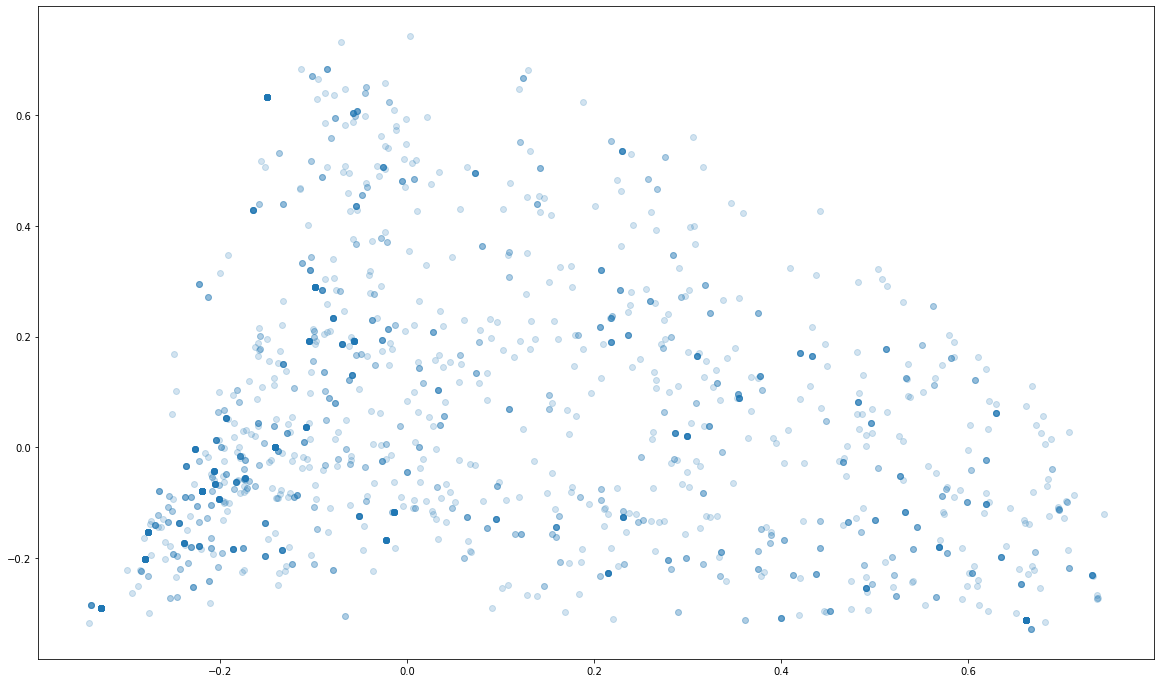

In [22]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

matrix_vectors = df_tfidf.to_numpy().tolist()

pca = PCA(n_components=2)
pca.fit(matrix_vectors)
X = pca.transform(matrix_vectors)

fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)

# Approximate Nearest Neighbour Tree

In [24]:
from annoy import AnnoyIndex
import random

labels = list(data.keys())
vectors = df_tfidf.to_numpy().tolist()

f = len(vectors[0])
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
i=0
print("adding vector..")
annoy_dict={}
for vector in vectors:
    t.add_item(i, vector)
    annoy_dict[labels[i]]=i
    i+=1
print(i,"vectors added")
t.build(10) # 10 trees
print("tree created")


adding vector..
2687 vectors added
tree created


In [25]:
#t.save('test.ann')
#u = AnnoyIndex(f, 'angular')
#u.load('test.ann') # super fast, will just mmap the file
search_word ="J01FA10"
# https://www.sefh.es/fichadjuntos/RESUMENINTERACCIONESCOVID19asma.pdf
ref_index = annoy_dict[search_word]
print("getting neighbour of ",labels[ref_index])
for neighbour in t.get_nns_by_item(ref_index, 10):
    print(labels[neighbour])



getting neighbour of  J01FA10
S01AA26
J01FA10
J01RA07
A02BD09
J01FA09
A02BD07
A02BD10
A02BD03
A02BD02
A02BD06


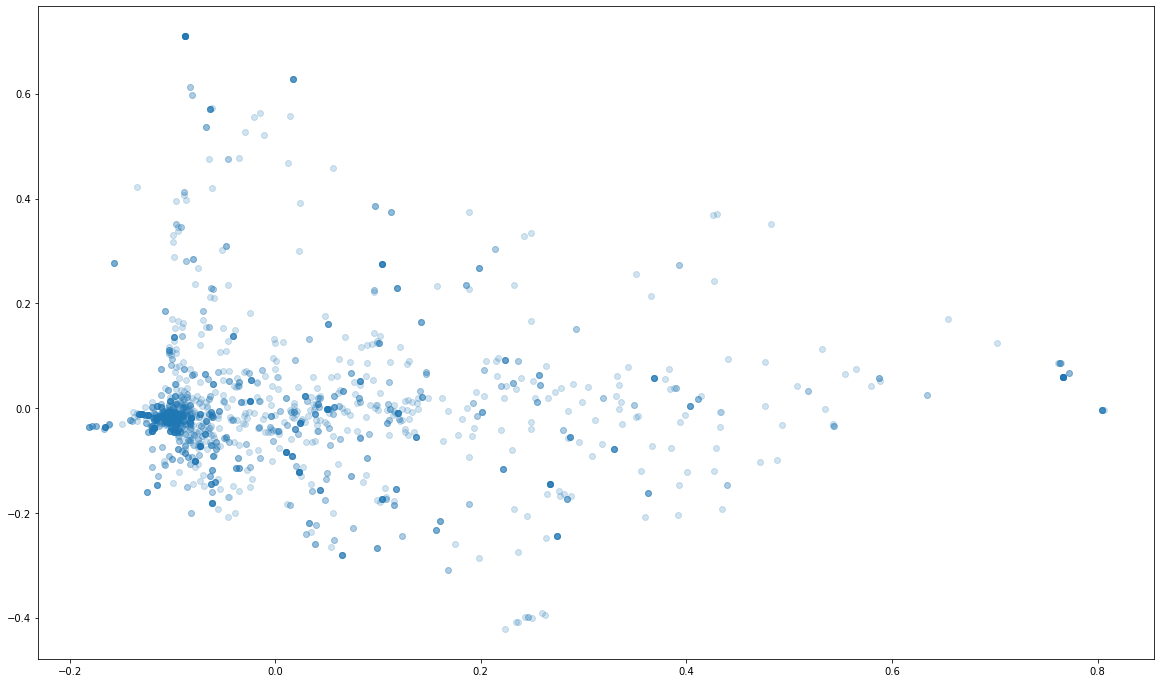

In [20]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

#temp_list = []
#for i in vector:
#    temp_list.append(list(i.A[0]))


pca = PCA(n_components=2)
#x_matrix = vector.todense()
#pca.fit(temp_list)
#dense_trsfm = trsfm.todense()
pca.fit(tfidf_list)
#X = pca.transform(temp_list)
X = pca.transform(tfidf_list)


fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)

#for i, txt in enumerate(df['title'].to_list()):
#    ax.annotate(txt, (X[:, 0][i], X[:, 1][i]))

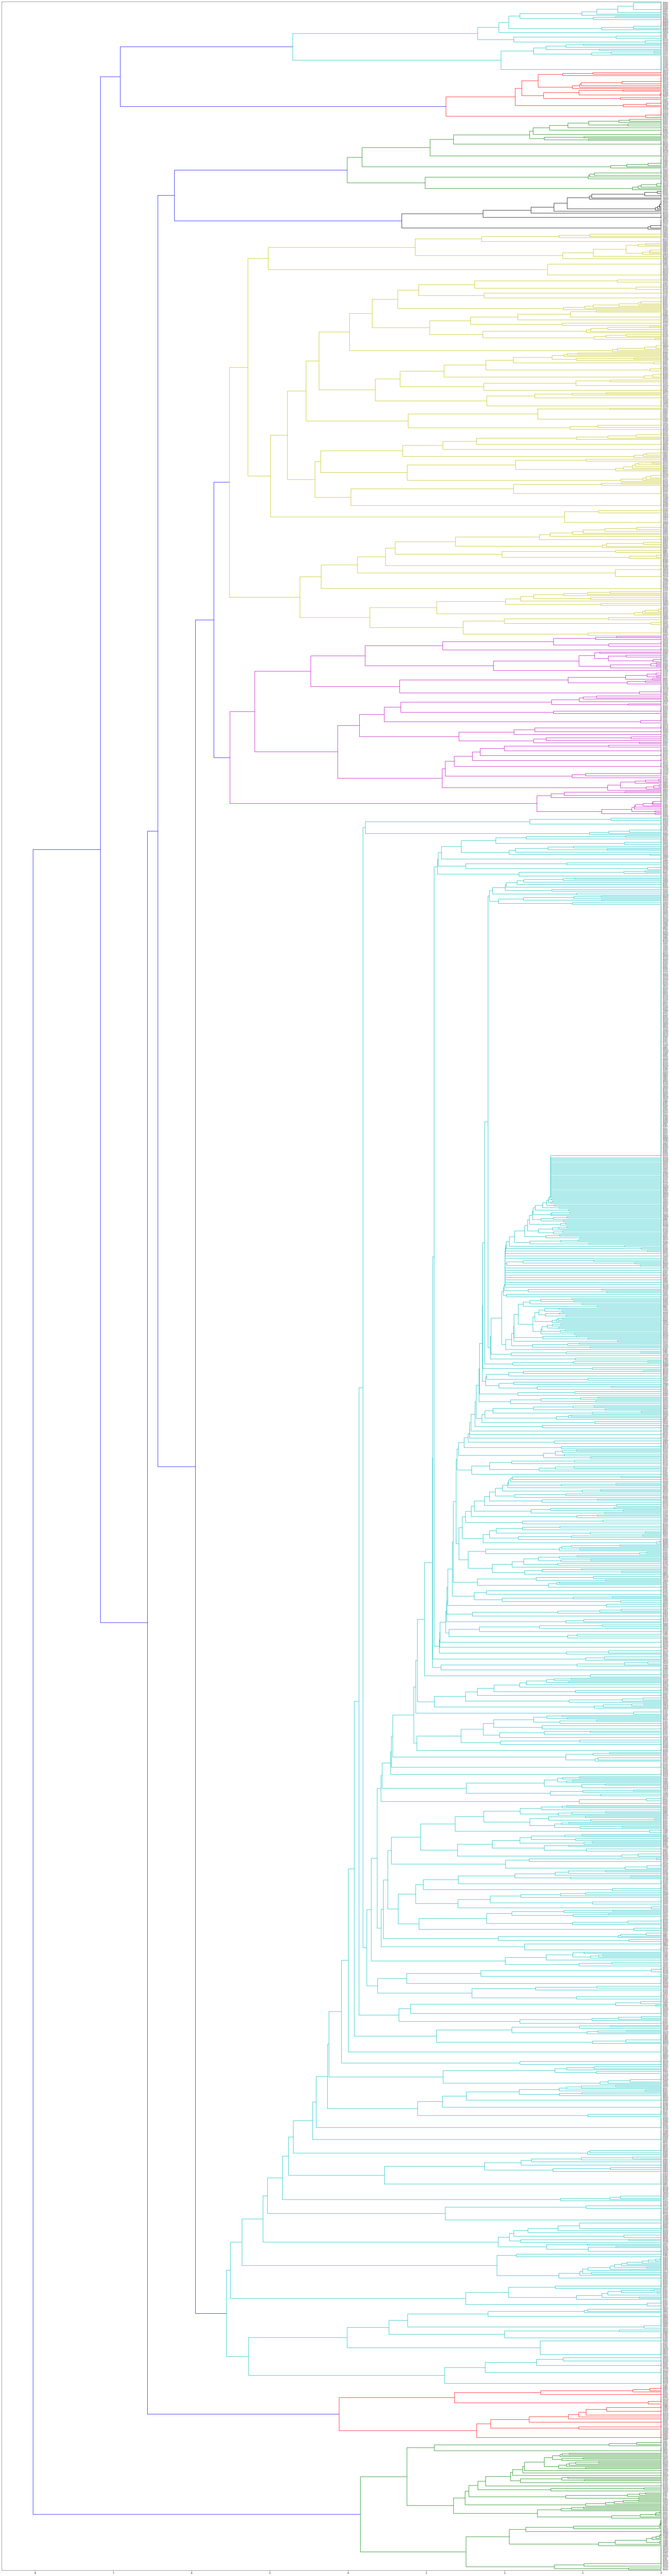

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

#  The distance function can be ‘braycurtis’, ‘canberra’, 
#‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, 
# ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, 
# ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

#dist = 1 - cosine_similarity(tfidf_matrix)
#MDS()
#mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
#pos = mds.fit_transform(tfidf_matrix.todense())  # shape (n_components, n_samples)

linked = linkage(tfidf_vectors, 'ward', 'euclidean')
#linked = linkage(X, 'average', 'cosine')
#linked = linkage(x_matrix, 'ward', 'euclidean')
#linked = linkage(X, 'ward', 'euclidean')

labelList = list(drugs.keys())

plt.figure(figsize=(50, 200))  
dendrogram(linked,  
            orientation='left',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [37]:
from sklearn.cluster import KMeans

num_clusters = 140

km = KMeans(n_clusters=num_clusters)

%time clusters=km.fit_predict(X)
#%time clusters=km.fit_predict(x_matrix)

#clusters = km.labels_.tolist()
print(clusters)

CPU times: user 2.12 s, sys: 283 ms, total: 2.4 s
Wall time: 867 ms
[ 33  33  33 ...  73 124  78]


In [38]:
solr = pysolr.Solr('http://librairy.linkeddata.es/data/atc')

atc_code_sample = "J05AB01"
atc_code_name = ""
for result in solr.search("code_s:"+atc_code_sample):
    atc_code_name = result['label_t']

sample_idx = labelList.index(atc_code_sample)
sample_cluster = clusters[sample_idx]
print("Cluster #", sample_cluster)

i = 0;
founds = []
for cluster in clusters:
    if (cluster == sample_cluster):
        founds.append(labelList[i])
    i+=1
print(len(founds),"drugs found related to",atc_code_sample,":",atc_code_name)
max = 10
for found in founds:
    for atc_code in solr.search("code_s:"+found):
        print("->",atc_code['code_s'],":",atc_code['label_t'])

Cluster # 94
30 drugs found related to J05AB01 : aciclovir
-> D01AA20 : topical antibiotic combinations
-> A07BC05 : diosmectite
-> J01CF04 : oxacillin
-> J05AX09 : maraviroc
-> L01CD02 : docetaxel
-> R05DA09 : dextromethorphan
-> N07XX59 : dextromethorphan, combinations
-> J01RA13 : norfloxacin and tinidazole
-> S01AD03 : aciclovir
-> D06BB03 : aciclovir
-> J05AB01 : aciclovir
-> D06BB53 : aciclovir, combinations
-> M04AA01 : allopurinol
-> M04AA51 : allopurinol, combinations
-> C10BA03 : pravastatin and fenofibrate
-> L01XE04 : sunitinib
-> L03AX16 : plerixafor
-> A02BX02 : sucralfate
-> A10AB30 : insulins and analogs for injection, fast-acting combinations
-> S01XA07 : alum
-> D11AX18 : diclofenac
-> M01AB05 : diclofenac
-> M02AA15 : diclofenac
-> S01BC03 : diclofenac
-> M01AB55 : diclofenac, combinations
-> S01CC01 : diclofenac and antiinfectives
-> N05AB04 : prochlorperazine
-> P03AX01 : benzyl benzoate
-> P01CD01 : melarsoprol
-> L03AX09 : thymopentin


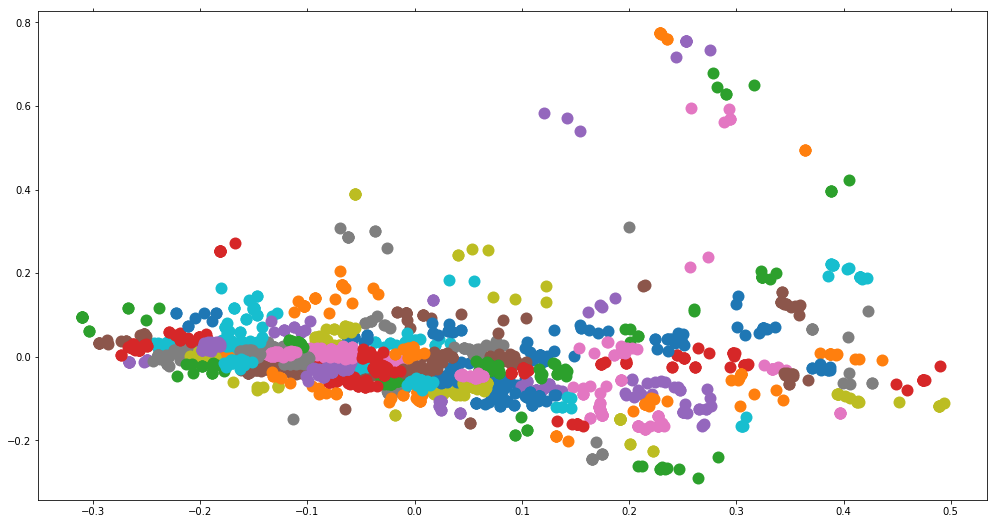

In [39]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

xs, ys = X[:, 0], X[:, 1]

#create data frame that has the result of the MDS plus the cluster numbers and titles
df2 = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=labelList)) 

#group by cluster
groups = df2.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    #ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
    #        label=cluster_names[name], color=cluster_colors[name], 
    #        mec='none')
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
             mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
#ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
    #ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

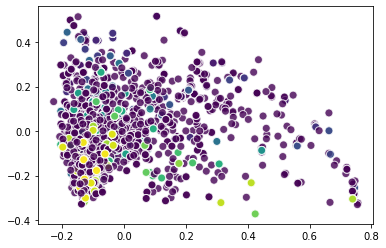

In [27]:
from sklearn.cluster import DBSCAN

dbs_1 = DBSCAN(eps=0.0001, min_samples=3)
labels_1 = dbs_1.fit(X).labels_ 

plt.scatter(X[:,0], X[:,1], c=labels_1,
                   alpha=0.8, s=64, edgecolors='white')
plt.show()

For n_clusters = 100 The average silhouette_score is : 0.436208445103141
For n_clusters = 110 The average silhouette_score is : 0.4494331459873356
For n_clusters = 120 The average silhouette_score is : 0.4576435692957037
For n_clusters = 130 The average silhouette_score is : 0.4553701275038375
For n_clusters = 140 The average silhouette_score is : 0.46024923069398316


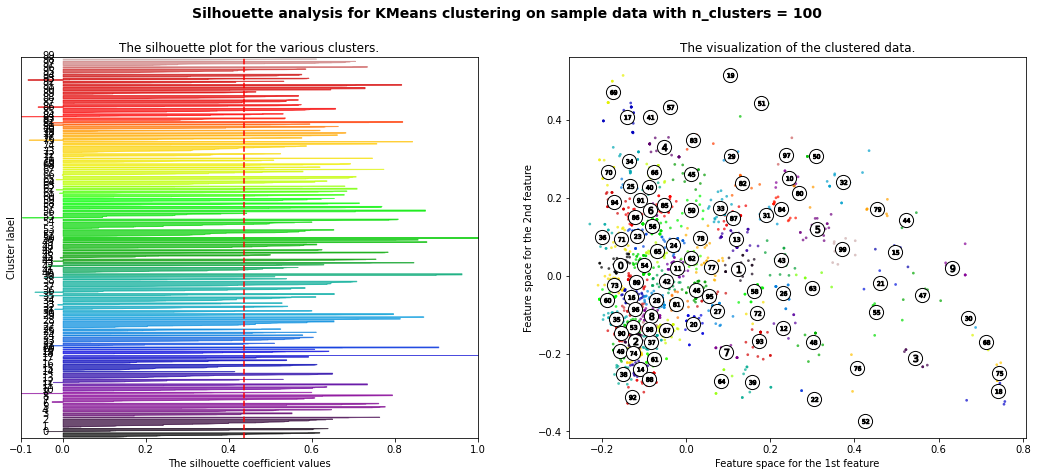

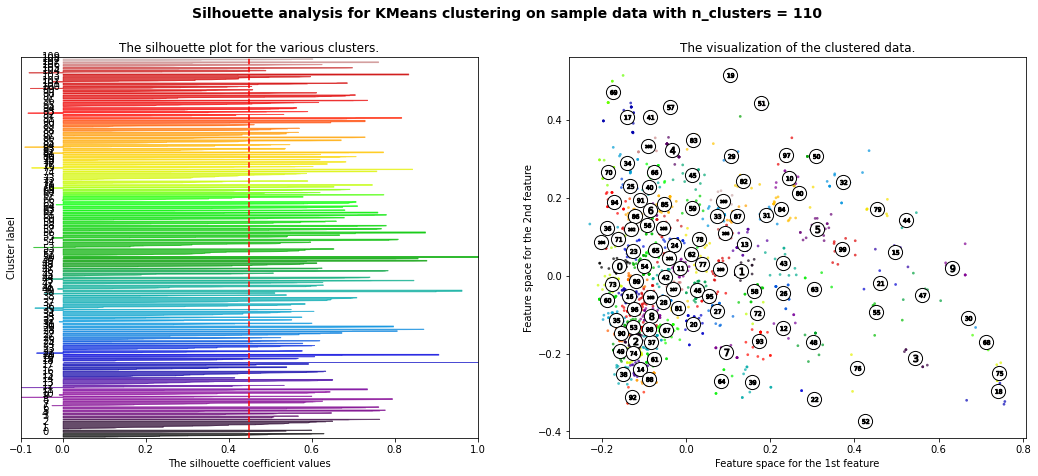

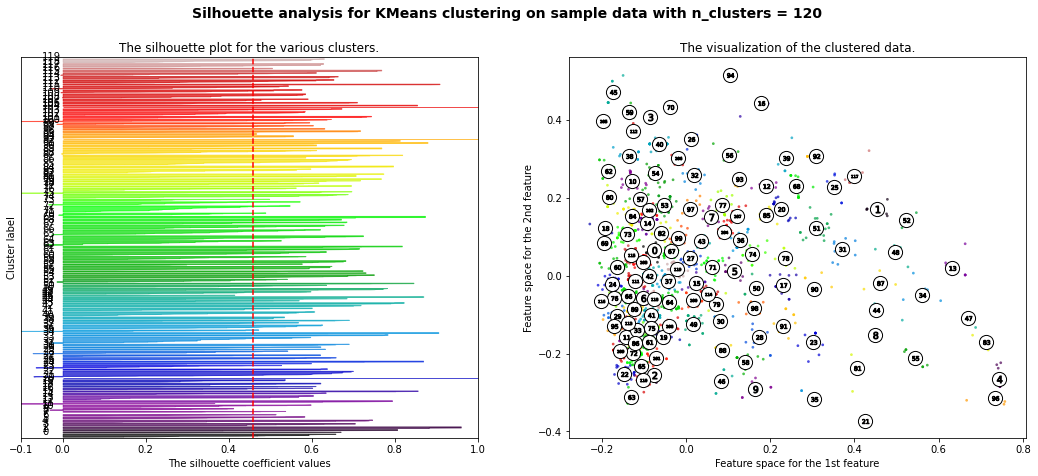

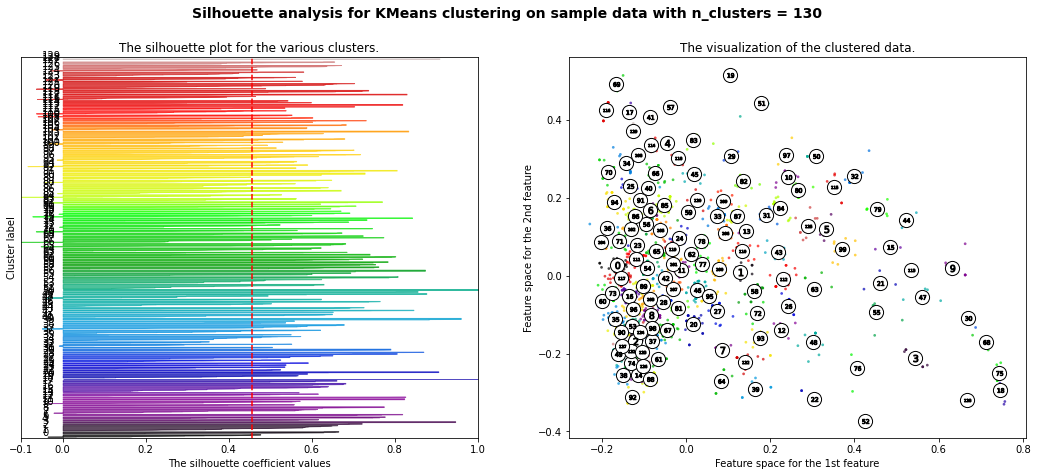

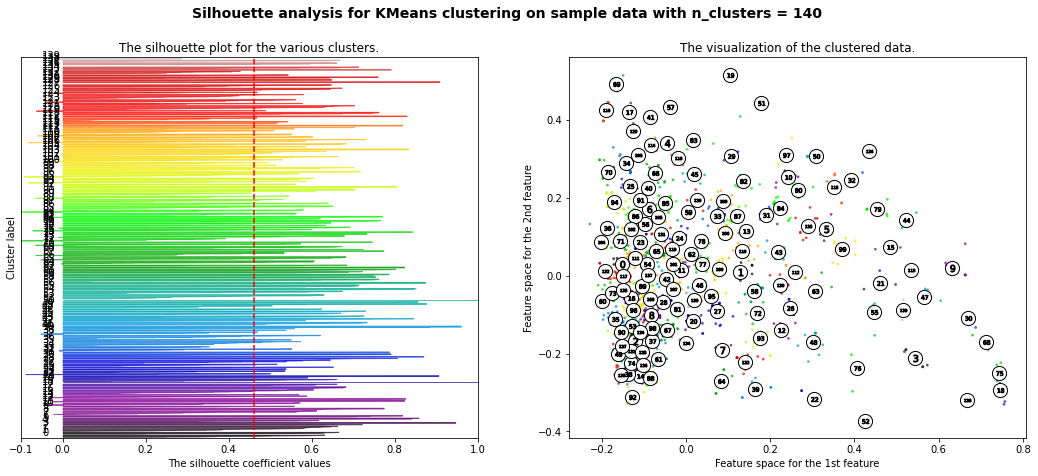

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [100, 110, 120, 130, 140]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# Some Queries

In [23]:
from annoy import AnnoyIndex

#Metric can be "angular", "euclidean", "manhattan", "hamming", or "dot".
class Space:
  def __init__(self, dimension, name, distance='euclidean',trees=1):
    self.name = name
    self.distance = distance
    self.trees = trees    
    self.vocab = []
    self.embedding_dict = {}
    self.size = 0
    self.dimension = dimension
    self.tree = AnnoyIndex(self.dimension, self.distance)
        
  def get_id(self):
    return self.name+"_"+self.distance[0]+"_"+str(self.trees)

  def get_vector(self,word):
    index  = self.embedding_dict[word]
    vector = self.tree.get_item_vector(index)
    array = np.array(vector) 
    return array
  
  def get_words(self,array,num):
    vector   = array.tolist()  
    nearest_idx = self.tree.get_nns_by_vector(vector, num)
    nearest_words = [self.vocab[i] for i in nearest_idx]
    return nearest_words

  def add_word(self,word,vector):
    if (self.dimension < 0):
      self.dimension = len(vector)
    self.vocab.append(word)  
    self.tree.add_item(self.size, vector)
    self.embedding_dict[word]=self.size
    self.size+=1

  def build(self):
    self.tree.build(self.trees)  
    
tfidf_vectors = df_tfidf.to_numpy().tolist()
    
dim = len(tfidf_vectors[0])    
space = Space(dim,"test")

i=0
for word in df['drug'].to_list():
    word_vector = tfidf_vectors[i]
    space.add_word(word,word_vector)
    i+=1
print(i,"words indexed in annoy")



2138 words indexed in annoy


In [24]:
import numpy as np
label = "N03AB03"
vector = space.get_vector(label)
print(vector)
for neighbour in space.get_words(vector,10):
    print(label,neighbour)
print("done!")

[0.         0.01796161 0.01796161 ... 0.         0.         0.        ]
done!


In [75]:
data_stats = {}
data_stats['annotation']=["bionlp_atc2_t","bionlp_atc3_t","bionlp_atc4_t","bionlp_atc5_t","pubchem_cids_t","scispacy_chemicals_t","scispacy_diseases_t","snomed_diseases_concept_id"]
#data_stats['frequency']=[303,11185,119796,315436,294582,103508,723575,759375]
data_stats['frequency']=[5,52,135,126,44,310,326,25]

df_stats = pd.DataFrame (data_stats, columns = ['annotation','frequency'])

df_stats.to_csv(base_directory+'/annotations.csv', index = False)
df_stats.head()

,annotation,frequency
0,bionlp_atc2_t,5
1,bionlp_atc3_t,52
2,bionlp_atc4_t,135
3,bionlp_atc5_t,126
4,pubchem_cids_t,44


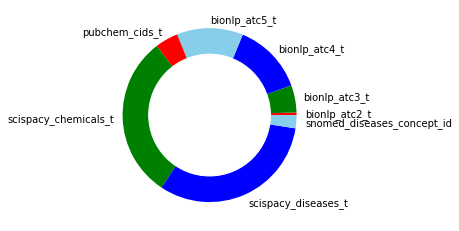

ValueError: Can not reset the axes.  You are probably trying to re-use an artist in more than one Axes which is not supported

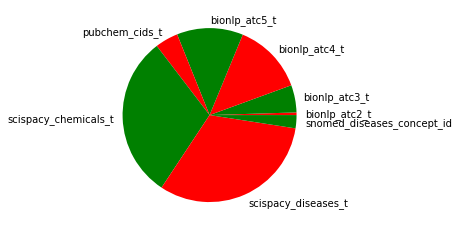

In [76]:
# library
import matplotlib.pyplot as plt
 
# create data
names=data_stats['annotation']
size=data_stats['frequency']
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
# Give color names
plt.pie(size, labels=names, colors=['red','green','blue','skyblue'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
 
# Custom colors --> colors will cycle
plt.pie(size, labels=names, colors=['red','green'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
 
from palettable.colorbrewer.qualitative import Pastel1_7
plt.pie(size, labels=names, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()


In [ ]:
print(space.tree.get_nns_by_item(0, 2))

In [ ]:
from annoy import AnnoyIndex
import random

f = 2
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
for i in range(13):
    v = [random.gauss(0, 1) for z in range(f)]
    print(v)
    t.add_item(i, v)

t.build(10) # 10 trees
t.save('test.ann')

# ...

u = AnnoyIndex(f, 'angular')
u.load('test.ann') # super fast, will just mmap the file
print(u.get_nns_by_item(0, 5)) # will find the 1000 nearest neighbors
